
# Assignment Set 6

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU


In [ ]:
path = {'train':'/kaggle/input/intel-image-classification/seg_train/seg_train',
        'validation': '/kaggle/input/intel-image-classification/seg_test/seg_test',
        'test': '/kaggle/input/intel-image-classification/seg_pred/seg_pred'}
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

buildings/  forest/  glacier/  mountain/  sea/  street/


## Define Pytorch Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(7*7*64, 7*7*16)
        self.fc2 = nn.Linear(7*7*16, 7*7)
        self.fc3 = nn.Linear(7*7, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x


cnn = CNN()

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.1, momentum=.5)

## Training Loop

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 32
         }
max_epochs = 100
transform = transforms.Compose([transforms.Resize((150,150)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

training_set = datasets.ImageFolder(root=path['train'], transform=transform)
training_generator = torch.utils.data.DataLoader(training_set, **params)
validation_set = datasets.ImageFolder(root=path['validation'], transform=transform)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

cnn.to(device)
train_epoch_loss = [] 
train_epoch_acc = [] 
val_epoch_loss = []
val_epoch_acc = [] 
for epoch in range(max_epochs):
    cnn.train()
    running_loss = []
    running_acc = []
    for local_batch, local_labels in training_generator:
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        optimizer.zero_grad()
        outputs = cnn(local_batch)
        loss = loss_function(outputs, local_labels)
        loss.backward()
        optimizer.step()
        running_loss += [loss.item()]
        _, predicted = torch.max(outputs, 1)
        running_acc += [(predicted == local_labels).sum().item()/params['batch_size']]
        
    train_epoch_loss += [np.mean(running_loss)]
    train_epoch_acc += [np.mean(running_acc)]
    
    cnn.eval()
    running_loss = []
    running_acc = []
    class_correct = np.zeros(6)
    class_total = np.zeros(6)
    with torch.no_grad():
        for local_batch, local_labels in validation_generator:
            local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            outputs = cnn(local_batch)
            loss = loss_function(outputs, local_labels)
            running_loss += [loss.item()]
            _, predicted = torch.max(outputs, 1)
            running_acc += [(predicted == local_labels).sum().item()/params['batch_size']]

    val_epoch_loss += [np.mean(running_loss)]
    val_epoch_acc += [np.mean(running_acc)]
    print('[{:d}] loss: {:7.5f} - acc: {:%} - val loss: {:7.5f} - val acc: {:%}'.format(epoch + 1, train_epoch_loss[-1],train_epoch_acc[-1], val_epoch_loss[-1],val_epoch_acc[-1]))

[1] loss: 1.62994 - acc: 39.375000% - val loss: 1.59450 - val acc: 44.335938%
[2] loss: 1.52116 - acc: 51.455966% - val loss: 1.50050 - val acc: 52.115885%
[3] loss: 1.49220 - acc: 54.176136% - val loss: 1.47094 - val acc: 54.947917%
[4] loss: 1.47449 - acc: 55.916193% - val loss: 1.45927 - val acc: 56.477865%
[5] loss: 1.45620 - acc: 57.812500% - val loss: 1.41858 - val acc: 60.970052%
[6] loss: 1.44720 - acc: 58.806818% - val loss: 1.51176 - val acc: 51.074219%
[7] loss: 1.43413 - acc: 60.284091% - val loss: 1.42574 - val acc: 59.375000%
[8] loss: 1.41416 - acc: 62.500000% - val loss: 1.43345 - val acc: 59.179688%
[9] loss: 1.40829 - acc: 62.762784% - val loss: 1.42913 - val acc: 59.602865%
[10] loss: 1.39438 - acc: 64.282670% - val loss: 1.46211 - val acc: 56.477865%
[11] loss: 1.38113 - acc: 65.710227% - val loss: 1.40436 - val acc: 61.816406%
[12] loss: 1.35953 - acc: 67.897727% - val loss: 1.35242 - val acc: 67.382812%
[13] loss: 1.34013 - acc: 69.829545% - val loss: 1.34398 - va

## Plot Model Accuracy

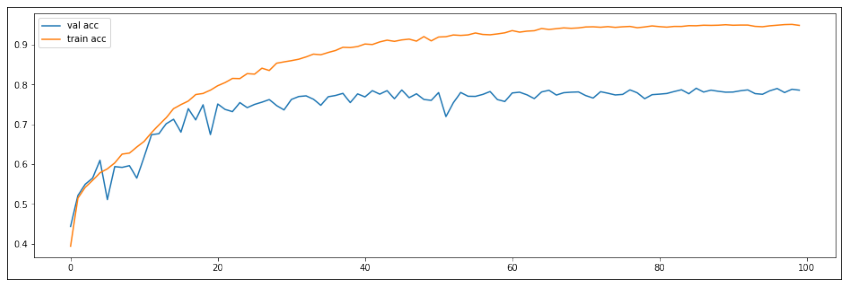

In [7]:
plt.figure(figsize=(16,5))
plt.plot(val_epoch_acc,label='val acc')
plt.plot(train_epoch_acc,label='train acc')
plt.legend()
plt.show()